# Chapter 6: Markov Chain Monte Carlo

## Introduction to Markov chains
Markov chain Monte Carlo (Markov Chain simulation or MCMC for short) is a Bayesian way of finding values of $\theta$ from an approximate distribution, where $\theta$ are the unknown parameters that make up the distribution. The Markov chain algorithm corrects this approximate distribution in each iteration, eventually converging to a final distribution that aligns with the posterior distribution $p(\theta|y)$ (for more on the posterior distribution, see [Chapter 4](https://bayesian-statistics-for-astrophysics-2024.readthedocs.io/en/latest/lecture_notes/group4/Chapter4.html)). This is particularly useful when the posterior is difficult or impossible to sample making MCMC a powerful tool.

This is done by constructing a stationary Markov chain, a sequence of random variables, $\theta_1, ... , \theta_t$, where the $\theta_t$ have the same distribution as the posterior. Now instead of taking independent variables, the Markov chain introduces variables $\theta_t$ obeying the Markov property

$$
	p(\theta_{t+1} | \theta_{t},...,\theta_1) = p(\theta_{t+1}|\theta_{t}),
$$
such that the variable $\theta_{t+1}$ is only dependent on the most recent variable $\theta_{t}$ and therefore, the distribution of $\theta_{t+1}$ does not depend on how the chain got to $\theta_{t}$, but only what this state is. In other words, one could say that "_What comes next is determined entirely by the present situation._"
Eventually, this converging of the distribution is where the power of Markov chain simulations lies, allowing for the determination of the original distribution solely from its data. 

Markov chain simulations are frequently used when it is inefficient to find $\theta$ directly from the posterior $p(\theta|y).$ As mentioned before, we sample a new $\theta$ iteratively, with the expectation that the distribution converges more and more to $p(\theta|y).$ Generally, MCMC is exceptionally effective for high-dimensional distributions, as direct-sampling Monte Carlo methods cannot complete such analysis in a reasonable time. 

MCMC algorithms, such as Metropolis-Hasting and affine parameters, propose and accept new steps of the MCMC chain in the parameter space, allowing the chain to explore the parameter space.

## Explanation of Metropolis-Hasting
The simplest method of simulating a Markov chain is the Metropolis-Hastings algorithm, which itself relies on the more basic Metropolis algorithm. This we will inquire about first.

The Metropolis algorithm expands on a random walk with a rule that accepts or rejects the sampled data to converge the sampled data to the specified target distribution. This accepting and rejecting is based on a given rule. The algorithm works as follows:
1. Draw a starting point $\theta_0$ with $p(\theta_0|y) > 0$ from a certain starting distribution $p_0(\theta)$. For example, $p_0(\theta) \sim \mathcal{N}(\theta_{t-1}, \sigma^2)$ if $\theta \in \mathbb{R}$.

2. For $t = 1, 2, \ldots$:

   a. Sample a proposal $\theta_\ast$ from a proposal distribution $J_t(\theta_\ast|\theta_{t-1})$ at time $t$. We require $J_t(\theta_a|\theta_b) = J_t(\theta_b|\theta_a)$ for all $\theta_a$, $\theta_b$, and $t$ for now.

   b. Calculate the ratio of the densities of $\theta_a$ and $\theta_b$:

      $$
      r = \frac{p(\theta_a|y)}{p(\theta_b|y)} = \frac{p(\theta_{\ast}|y)}{p(\theta_{t-1}|y)}.
      $$
      
   c. Set 

      $$
      \theta_t = \begin{cases}
         \theta_\ast &\ \text{with probability } \min(r, 1), \\
         \theta_{t-1} &\ \text{otherwise}.
      \end{cases}
      $$

To put this into words; a value of $\theta_*$ is sampled from a previous distribution, and if the ratio of densities is lower than a random uniform variable, the proposed state is rejected and $\theta_t$ = $\theta_{t-1}$.

Now we return to the Metropolis-Hastings (MH) algorithm. In contrast to the Metropolis algorithm, the MH algorithm does not require $J_t(\theta_*|\theta_{t-1})$ to be symmetric. Due to this new, asymmetric proposal distribution, we must alter the ratio of densities of $\theta_a$ and $\theta_b$, which is as follows:

$$ 
r = \frac{p(\theta_{\ast}|y)J_t(\theta_{t-1}|\theta_{\ast})}{p(\theta_{t-1}| y)J_t(\theta_{\ast}|\theta_{t-1})}
$$

For the proposal distribution, the following characteristics are favorable:
- It is easy to sample from $ J(\theta_{\ast}|\theta) $ for any $\theta$.
- The ratio of $r$ (as given by the above equation) is easy to calculate.
- The random walk does not go too slowly, i.e., the sampled values are not too close together.
- Rejected jumps do not happen often, as they hurt the performance of the algorithm.


### Burn-in Time and Autocorrelation
In the Metropolis-Hastings algorithm, the chain takes some steps to reach a stable value, called the burn-in time. We discard these points before we make the probability distribution. In a one-parameter fit, this can easily be done by eye. However, in fits with many parameters, you would prefer an automated process to take care of this. This can be done via autocorrelation. If we have the chain $\{X_1, X_2,...,X_n\}$ we can calculate the autocorrelation coefficient with
$$
\rho(k)=\frac{1}{(n-k)\sigma^2}\sum_{t=1}^{n-k}(X_t-\mu)(X_{t+k}-\mu) \tag{6.1}
$$
where $k$ is the lag or time gap between the samples and $\mu$ the mean. We can choose a threshold value, say 0.1, and calculate above which value of $k$ the autocorrelation coefficient is below the threshold. We can then take $\{X_k,...,X_n\}$ to be samples from our posterior distribution. In the example below we will use autocorrelation to determine the burn-in time.

### 1D Example
We have collected data and want to infer the mean and its error. The data points are $y_i=$[1,2,3] with error $\sigma_{y_i}=$[1,1,1]. We can do this analytically and find $\mu=2$ and $\sigma_\mu=1/\sqrt{3}\approx0.577$. We want to derive these values using the Metropolis-Hasting algorithm. First, we need to construct the posterior. We will assume a flat prior making the posterior the likelihood. Next, we pick a starting point for the Markov chain. Using this as the center of a normal distribution, a new point is drawn from the distribution. We find the ratio of the new points posterior to the last point. If the ratio is larger than a random value between 0 and 1, we accept the new point to the chain. Otherwise, the last point value is added to the chain. These steps are repeated until we can reconstruct the desired distribution for $\mu$. We take 10 as the starting point and use a starting distribution with a scale parameter of 3. This allows the chain to converge to the correct value quickly. 

As mentioned before, the chain takes some steps to get to a stable value. We disregard these points before we make the probability distribution. 



The burn-in time is at step 19.


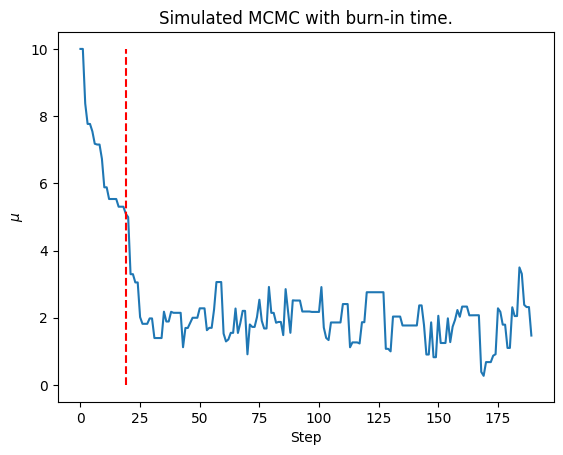

Simulated mean: 2.014, True mean: 2
Simulated error: 0.575, True error: 1/√3


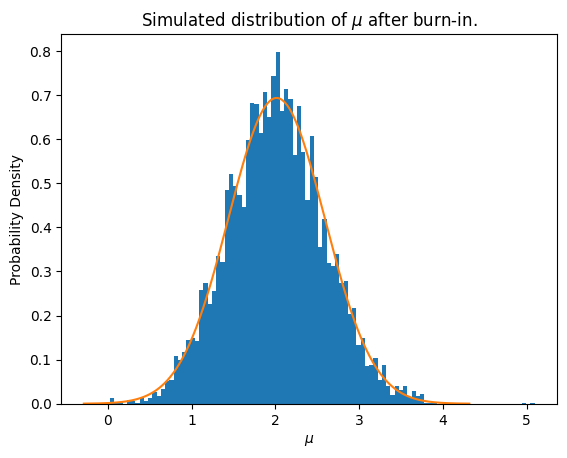

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

steps = 10000
X = 10
Xs = []
y = np.array([1, 2, 3])
y_sigma = np.array([1, 1, 1])


def prob_dist(mu):
    return np.exp(-1 * np.sum(((y - mu) ** 2 / (2 * y_sigma ** 2))))


def autocorrelation(chain, lag):
    return np.sum((chain[:len(chain) - lag] - np.mean(chain)) * (chain[lag:] - np.mean(chain))) / (
                len(chain) - lag) / np.var(chain)


for _ in range(steps):
    Y = np.random.normal(X, 1)
    q = prob_dist(Y) / prob_dist(X)
    if q >= np.random.rand():
        X = Y
    Xs.append(X)


auto = np.inf
index = 1
while auto >= 0.01:
    auto = autocorrelation(Xs, index)
    index += 1
    if index >= len(Xs):
        print('autocorrelation failed')
        break
        
print(f'The burn-in time is at step {index}.')
plt.figure()
plt.plot(Xs[:10 * index])
plt.vlines(index, 0, 10, colors='red', linestyles='dashed')
plt.xlabel('Step')
plt.ylabel(r'$\mu$')
plt.title('Simulated MCMC with burn-in time.')
plt.show()


plt.figure()
plt.hist(Xs[index:], bins=steps // 100, density=True)
mu = np.mean(Xs[index:])
mu_sigma = np.std(Xs[index:])
print(f'Simulated mean: {mu:.3f}, True mean: 2')
print(f'Simulated error: {mu_sigma:.3f}, True error: 1/√3')
x = np.linspace(mu - 4 * mu_sigma, mu + 4 * mu_sigma, 1000)
plt.plot(x, norm.pdf(x, mu, mu_sigma))
plt.xlabel(r'$\mu$')
plt.ylabel('Probability Density')
plt.title(r'Simulated distribution of $\mu$ after burn-in.')
plt.show()

## Explanation of affine-invariant algorithms (used in emcee)
### Affine invariance
While the Metropolis-Hasting implementation may be particularly useful for some distributions, it fails for badly scaled or highly skewed distributions. In 2010, Goodman and Weare suggested the use of affine invariant many particle MCMC samplers, where they make use of affine transformations of the form 
\begin{equation*}
    y \longmapsto Ax +b. \tag{6.2}
\end{equation*}
Furthermore, if a sample $X$ has probability density $p(x)$, then the affine transformed $Y = AX + b$ has probability density $p(y) = p(Ax+b) \propto p(x)$.

Rescaling the distribution allows for easier computations with less customization. For example, the Metropolis MCMC application would have difficulty analyzing an anisotropic density like

<a id="eq:SKE"></a>
\begin{equation}
    p(x) \propto \exp{\left(-\frac{(x_1 - x_2)^2}{2a} - \frac{(x_1 + x_2)^2}{2}\right)}
\end{equation}

as it will have to make small steps of the order of $\sqrt{a}$, which results in a long burn-in time until the Markov chain reaches equilibrium.

Using the suited affine transformation 

\begin{equation}
    y_1 = \frac{x_1 - x_2}{\sqrt{a}}, \hspace{1cm} y_2 = x_1 + x_2
\end{equation}

we can alter this problem into a well-scaled case

<a id="eq:WELL"></a>
\begin{equation}
    p(y) \propto \exp{\left(\frac{-(y_1 + y_2)^2}{2}\right)}. \tag{6.3}
\end{equation}
Where $p(y)$ is much easier to sample than the initial probability density of $p(x)$. 

For an affine invariant algorithm, the two cases of $p(x)$ and $p(y)$ are the same and equally difficult, such that it does not depend on the parameter $a$ that determines the aspect ratio of the distribution. 

|             ![Skewed data set](Skewed_pdf.png)             |           ![Transformed data set](Transformed_pdf.png)           |
|:----------------------------------------------------------:|:----------------------------------------------------------------:|
| **Figure 1:** Skewed data set given in [Eq. 6.2](#eq:SKE). | **Figure 2:** Transformed data set given in [Eq. 6.3](#eq:WELL). |

Let us create two Monte Carlo runs with an identical sequence of independent identically distributed variables and we use the two densities $p(x)$ and $p(y)$. If our algorithm is affine invariant, it must obey that $Y(t) = AX(t) + b$ (given initial points $X(0)$ for $p(x)$ and $Y(0) = AX(0) + b$ for $p(y)$).

### Stretch Move
Instead of using a single chain of walkers, affine-invariant algorithms use an ensemble of walkers. In this case, the updated position of each walker is based on the current position of the other walkers in the ensemble. When using an ensemble of $K$ walkers $S = \{X_k\}$, the position is updated by drawing a random walker from the complementary space $S_{[k]} = \{X_j, \forall j \neq k\}$

Then a new position is proposed as follows:
\begin{equation}
    X_k(t) \rightarrow Y = X_j + Z[X_k(t) - X_j]
\end{equation}

where $Z$ is a randomly chosen scaling factor from the distribution $g(z)$. Typically, it is proposed that:
\begin{equation}
    g(z) \propto \begin{cases}
        \frac{1}{\sqrt{z}} & \text{if\ } z \in [\frac{1}{a}, a] \\
	0 & \text{otherwise}.
			     \end{cases}
\end{equation}

This implementation of the invariant algorithm is informally called the \textquotedblleft stretch move\textquotedblright. The autocorrelation time for this method is much shorter than that of typical MCMC methods like the Metropolis-Hastings algorithm. 


### The parallel stretch move
Whilst using the stretch move is much more efficient than simpler algorithms like Metropolis-Hastings, the walkers are updated in series, one after another. If we could evolve them all in parallel this may significantly improve the autocorrelation time. 

This is not entirely feasible in EMCEE as this would violate detailed balance. Detailed balance ensures that the chain is reversible, allowing for sampling from the correct target distribution. However, an alternative is to split our ensemble of $K$ walkers $S = \{X_k\}$ into two subsets $S^{(0)} = \{X_k \forall k \in [1, K/2]\}$ and $S^{(1)} = \{X_k \forall k \in [K/2 + 1, K]\}$ and run these in parallel. One can observe that these two subsets are now each others complementary space $S_{[k]}$ and, therefore, we evolve the walkers in $S^{(0)}$ only by positions in $S^{(1)}$ (and vice versa) using the stretch move discussed above. Each walker in subset $S^{(0)}$ can now be evolved independent of the others in that subset. 

Even though the autocorrelation time does not improve significantly compared to the regular stretch move, by using this method we unlock generic parallelization, allowing for multi-threading and distributed computing, which makes this method especially applicable for modern hardware architectures.

### References


[Budd, T. 2024, Monte Carlo Techniques](https://hef.ru.nl/~tbudd/mct/lectures/markov_chain_monte_carlo.html)

[Foreman-Mackey, D., Hogg, D. W., Lang, D., & Good-
man, J. 2013, Publications of the Astronomical Soci-
ety of the Pacific, 125, 306–312](https://arxiv.org/pdf/1202.3665)

[Gelman, A., Carlin, J. B., Stern, H. S., et al. 2013,
Bayesian Data Analysis, 3rd edn., Chapman Hal-
l/CRC Texts in Statistical Science Series (Boca Ra-
ton, Florida: CRC)](http://www.stat.columbia.edu/~gelman/book/BDA3.pdf)

[Goodman, J. & Weare, J. 2010, Communications in Ap-
plied Mathematics and Computational Science, 5, 65](https://msp.org/camcos/2010/5-1/p04.xhtml)

[Nagler, T. 2021, Statistics for Astronomy and
Physics Students, Creative Commons Attribution-
NoDerivatives 4.0 International (CC BY-ND 4.0),
lecture notes, Fall 2020, Version: June 21, 2021](https://tnagler.github.io/stan-2020.pdf)

[Wang, W. 2022, American Journal of Physics, 90,
921–934](https://arxiv.org/pdf/2204.10145)
